# User and Session agnostic - Video based

In [1]:
#imports
import string
import pandas as pd
import pickle as pkl
from collections import Counter
from matplotlib import pyplot as plt

import numpy as np
from random import sample

import fasttext
from sentence_transformers import SentenceTransformer
from gensim.models.fasttext import load_facebook_model

import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def train_tfidf(corpus):
    corpus = [preprocess_sentence(x) for x in corpus]
    tfidf = TfidfVectorizer()
    tfidf.fit(corpus)
    return tfidf

def get_tfidf(sentence, tfidf):
    sentence = preprocess_sentence(sentence)
    sentence = tfidf.transform([sentence])
    return sentence

In [3]:
vd = pd.read_pickle('video-dump-with-embeddings+transcript')

In [9]:
keys = list(vd.keys())

In [14]:
transcripts = dict()

for vid in vd:
    transcripts[vid] = vd[vid]['transcript']

In [16]:
len(transcripts)

137803

In [17]:
from itertools import islice

def chunks(data, SIZE=10000):
    it = iter(data)
    for i in range(0, len(data), SIZE):
        yield {k:data[k] for k in islice(it, SIZE)}
        
chh = list(chunks(transcripts))

In [24]:
pkl.dump(transcripts, open('transcripts.pkl', 'wb'))

In [81]:
# embedding functions

bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
ft_model = load_facebook_model('../Search Results/dump/wiki.en.bin')

def word_embedding(word):
    return ft_model.wv[word]

def sentence_embeddings(sentences):
    return bert_model.encode(sentences)

def sentence_embedding(sentence):
    return bert_model.encode(sentence)

def preprocess_sentence(sentence):
    if not isinstance(sentence, str):
        return ''
    sentence = sentence.lower()
    # remove punctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    # remove numbers
    sentence = re.sub(r'\d+', '', sentence)
    #lemmatize
    lemmatizer = WordNetLemmatizer()
    sentence = ' '.join([lemmatizer.lemmatize(word) for word in sentence.split(' ')])
    return sentence


def sentence_embedding_fasttext(sentence):
    sentence = preprocess_sentence(sentence)
    sentence = title_tfidf.transform([sentence])
    sentence = sentence.toarray()
    sentence = np.dot(sentence, title_embs)
    return sentence[0]

In [82]:
#video functions

def get_id(url):
    if len(url.split('v=')) <= 1:
        return None
    url = url.split('v=')[1]
    url = url.split('&')[0]
    return url

def decode_upnext(urls):
    urls = eval(urls.decode('utf-8'))
    ids = []
    for u in urls:
        ids.append(get_id(u))
    return ids

In [83]:
def similarity(a, b):
    cosine_similarity = lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
    return cosine_similarity(a, b)

In [84]:
sessions = pd.read_pickle('all_sessions')
video_db = pd.read_pickle('videos-db-meta')

# Single Step Data (only access to this video)
ss_session = []
for session in sessions:
    for video, next_video, in zip(session[:-1], session[1:]):
        video['selected'] = next_video['url']
        ss_session.append(video)


data = pd.DataFrame(ss_session)
data['url'] = data['url'].apply(get_id)
data['selected'] = data['selected'].apply(get_id)
data['upnext_content'] = data['upnext_content'].apply(decode_upnext)
data = data[['url', 'upnext_content', 'selected']]
data.columns = ['video', 'upnext', 'selected']
data.head()

,video,upnext,selected
0,489B7RNudAQ,"[ZOZyo6YOAu4, VtYi8AR11WM, Q32BGQmVLJ0, h1BsKI...",Q32BGQmVLJ0
1,jnXeE4TY2so,"[MeH-4wEuvZs, h1BsKIP4uYM, dqbyJIKLxok, VX4n8w...",HtyVbMZegn4
2,NQPNRwpGWXc,"[2PopspP_DbI, VPrrIGxjubI, 4s2ynUAJ5ZU, dEk8Hb...",VPrrIGxjubI
3,8tsnuvfMmtc,"[4iYl9oSjffQ, mTHedRdHJgk, aeWyp2vXxqA, 6S7VkI...",aeWyp2vXxqA
4,LcW4MCa5YCQ,"[-TgFz3qmE9U, 9scfWN6aXaU, O7VaXlMvAvk, h1BsKI...",z0Xpye7Ltlo


### Baseline

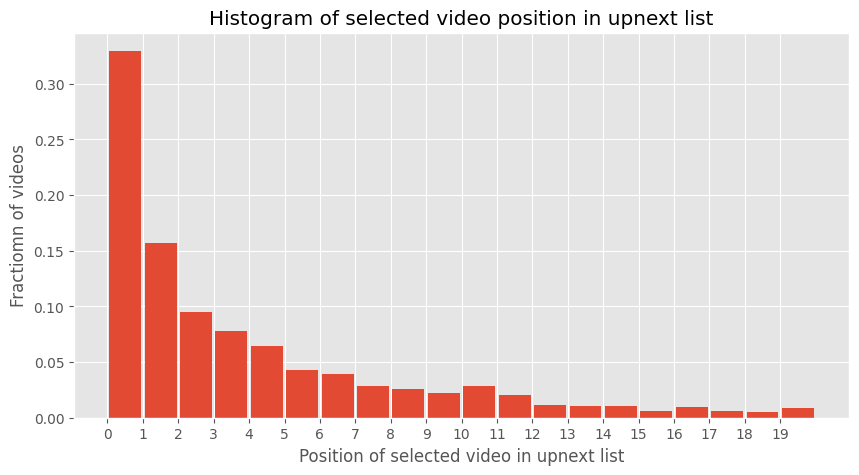

Baseline accuracy: 0.329


In [192]:
upnexts = list(data['upnext'])
selected = list(data['selected'])

indexes = []
for upnext, s in zip(upnexts, selected):
    indexes.append(upnext.index(s))

indexes = np.array(indexes)
indexes[indexes > 20] = 20

plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.hist(indexes, bins=20, rwidth=0.9, density=True)
plt.xticks(np.arange(20), np.arange(20))
plt.xlabel('Position of selected video in upnext list')
plt.ylabel('Fraction of videos')
plt.title('Histogram of selected video position in upnext list')
plt.show()

# baseline accuracy
print('Baseline accuracy:', round(Counter(indexes)[0]/len(data), 3))

### Convert to video object sessions

In [89]:
class Video:
    def __init__(self, uid): 
        self.uid = uid
        if uid not in video_db:
            self.title, self.tags, self.description, self.category, self.channel_title = None, None, None, None, None
            return

        vs = video_db[uid]['snippet']
        self.title = vs['title']
        self.tags = vs.get('tags', [])
        self.description = vs['description']
        self.category = vs['categoryId']
        self.channel_title = vs['channelTitle']
        
        self.get_tag_embeddings()
        self.get_title_embedding()
        self.get_description_embedding()


    def get_tag_embeddings(self):
        self.tags_emb = []
        for tag in self.tags:
#             self.tags_emb.append(TAG_EMBS[tag])
              self.tags_emb.append(word_embedding(tag))

    def get_title_embedding(self):
#         self.title_emb = TITLE_EMBS[self.title]
        self.title_emb = sentence_embedding(self.title)

    def get_description_embedding(self):
#         self.description_emb = DESC_EMBS[self.description]
        self.desc_emb = sentence_embedding(self.description)

    def __repr__(self):
        if self.title is None:
            return 'Video not found'
        return self.title
    
    def __str__(self):
        if self.title is None:
            return 'Video not found'
        return self.title
    
    def __hash__(self):
        return hash(self.uid)

In [90]:
# title_corpus = []
# for session in video_sessions:
#     title_corpus.append(session['video'].title)
#     for upnext in session['upnext']:
#         title_corpus.append(upnext.title)

# title_tfidf = train_tfidf(title_corpus)

# tokens = title_tfidf.get_feature_names_out()

# token_embeddings = {}
# for token in tokens:
#     token_embeddings[token] = word_embedding(token)

# title_embs = np.array(list(token_embeddings.values()))

In [135]:
titles = dict()
descs = dict()
tagss = dict()

uids = list(video_db.keys())
for uid in uids:
    title = video_db[uid]['snippet']['title']
    tags = video_db[uid]['snippet'].get('tags', [])
    description = video_db[uid]['snippet']['description']
    
    titles[uid] = title
    descs[uid] = description
    tagss[uid] = tags

In [ ]:
for i in tqdm([1]):
    title_embs = sentence_embeddings(list(titles.values()))
    desc_embs = sentence_embeddings(list(descs.values()))
    for uid in tagss:
        tags = [word_embedding(tag) for tag in tagss[uid]]
        tagss[uid] = tags

  0%|          | 0/1 [00:00<?, ?it/s]

In [140]:
for i in video_db[]

In [153]:
uids = list(video_db.keys())
for i, uid in enumerate(uids):
    video_db[uid]['embeddings'] = dict()
    video_db[uid]['embeddings']['title'] = title_embs[i]
    video_db[uid]['embeddings']['description'] = desc_embs[i]
    video_db[uid]['embeddings']['tags'] = tagss[uid]

In [154]:
pkl.dump(video_db, open('video-dump-with-embeddings', 'wb'))

# Transcript

In [162]:
import os
import json
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api.formatters import TextFormatter

In [169]:
def get_transcript(uid):
    transcript = YouTubeTranscriptApi.get_transcript(uid)
    formatter = TextFormatter()
    string_formatted = formatter.format_transcript(transcript)
    transcript = string_formatted.split('\n')
    return transcript

In [ ]:
for uid in tqdm(video_db):
    if len(video_db[uid]['transcript']) > 0:
        continue
    try:
        transcript = get_transcript(uid)
    except Exception as e:
        print(e)
        transcript = []
#     video_db[uid]['transcript'] = transcript

  0%|          | 0/137803 [00:00<?, ?it/s]


Could not retrieve a transcript for the video https://www.youtube.com/watch?v=atz_aZA3rf0! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!

Could not retrieve a transcript for the video https://www.youtube.com/watch?v=U-ImDa6KP8o! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are u


Could not retrieve a transcript for the video https://www.youtube.com/watch?v=zaP8NGML_QE! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!

Could not retrieve a transcript for the video https://www.youtube.com/watch?v=FyTfLMLnjL8! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are u


Could not retrieve a transcript for the video https://www.youtube.com/watch?v=qb4HT26wNcU! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!

Could not retrieve a transcript for the video https://www.youtube.com/watch?v=v0jVb9TmfRM! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are u


Could not retrieve a transcript for the video https://www.youtube.com/watch?v=BnoCHlybAnU! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!

Could not retrieve a transcript for the video https://www.youtube.com/watch?v=EwKI5OnZapk! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are u

In [189]:
pkl.dump(video_db, open('video-dump-with-embeddings+transcript', 'wb'))

In [177]:
a = []
for uid in tqdm(video_db):
#     try:
#         transcript = get_transcript(uid)
#     except:
#         transcript = []
    a.append(len(video_db[uid]['transcript']))

  0%|          | 0/137803 [00:00<?, ?it/s]

In [184]:
i = pd.DataFrame(a, columns =['leng'])
i[i['leng'] < 1]

,leng
0,0
1,0
2,0
4,0
7,0
...,...
137792,0
137795,0
137796,0
137798,0


In [ ]:
from tqdm.notebook import tqdm as tqdm

video_sessions = []
ss_sessions = data.to_dict('records')

for session in tqdm(ss_sessions):
    video_session = {}
    video_session['video'] = Video(session['video'])
    video_session['upnext'] = []
    for upnext in session['upnext']:
        video_session['upnext'].append(Video(upnext))
    video_session['selected'] = Video(session['selected'])
    video_sessions.append(video_session.copy())

In [18]:
titles = []
descriptions = []
tags = []
for session in video_sessions:
    titles.append(session['video'].title)
    descriptions.append(session['video'].description)
    tags.append(session['video'].tags)
    for upnext in session['upnext']:
        titles.append(upnext.title)
        descriptions.append(upnext.description)
        tags.append(upnext.tags)

In [22]:
tt = []

for title in titles:
    if title is None:
        continue
    tt.append(title)

In [25]:
embs = sentence_embeddings(tt)

TITLE_EMBS = {}
for title, emb in zip(tt, embs):
    TITLE_EMBS[title] = emb

In [70]:

embs = sentence_embeddings(descriptions)

DESC_EMBS = {}
for desc, emb in zip(descriptions, embs):
    DESC_EMBS[desc] = emb


tags_list = []
for tl in tags:
    if tl is None:
        continue
    for t in tl:
        tags_list.append(t)

# tag_list = set(tags_list)
# TAG_EMBS = {}
# for tag in tqdm(tag_list):
#     TAG_EMBS[tag] = word_embedding(tag)

In [ ]:
len(video_sessions)

In [1]:
#titles

In [66]:
from tqdm.notebook import tqdm as tqdm

video_sessions = []
ss_sessions = data.to_dict('records')

for session in tqdm(ss_sessions):
    video_session = {}
    v = Video(session['video'])
    video_session['video'] = Video(session['video'])
    video_session['upnext'] = []
    for upnext in session['upnext']:
        video_session['upnext'].append(Video(upnext))
    video_session['selected'] = Video(session['selected'])
    video_sessions.append(video_session)

  0%|          | 0/8563 [00:00<?, ?it/s]

In [58]:
len(TITLE_EMBS.keys())

50

In [ ]:
!pip3 install YouTubeTranscriptApi

In [ ]:
import os
import json
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api.formatters import TextFormatter

In [136]:
# BERT
video = video_sessions[63]['video']
upnext = video_sessions[63]['upnext']
selected = video_sessions[63]['selected']

video_embd = sentence_embedding(video.title)
upnext_embd = [sentence_embedding(x.title) for x in upnext]

sim = [1]
for i, j in zip(upnext, upnext_embd):
    sim.append(similarity(video_embd, j))

pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(sim, columns = ['similarity'])
df['title'] = [x.title for x in [video] + upnext]
df.sort_values('similarity', ascending=False)

,similarity,title
0,1.000000,Guy Under Arrest Won't Get Out Of The Car
6,0.638865,Here's Why You Shouldn't Run From The Police #5
17,0.582922,What Happens If You Try To Block Traffic On Ze Autobahn?
11,0.545706,Cops Arrest Blind Man For Having A Cane
2,0.482283,Alleged Cop Impersonator Gets Arrested by Georgia Police
4,0.482068,"Allegedly Drunk Florida Deputy Found Asleep, Hanging Out of Car"
12,0.480199,The Big Misconception About Electricity
13,0.470790,She Said She Didn't Realize She Hit Someone
3,0.425112,"Murder Suspect Calls Cops Over Cold McDonald's Fries, Gets Arrested"
8,0.409989,"SHOCK MOMENT: Jordan Confronts Dem Witness With Transcript & Audio, Accuses Him Of Lying To Congress"


In [135]:
# FastText

video = video_sessions[63]['video']
upnext = video_sessions[63]['upnext']
selected = video_sessions[63]['selected']

video_embd = sentence_embedding_fasttext(video.title)
upnext_embd = [sentence_embedding_fasttext(x.title) for x in upnext]


sim = [1]
for i, j in zip(upnext, upnext_embd):
    sim.append(similarity(video_embd, j))

pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(sim, columns = ['similarity'])
df['title'] = [x.title for x in [video] + upnext]
df.sort_values('similarity', ascending=False)

,similarity,title
0,1.000000,Guy Under Arrest Won't Get Out Of The Car
5,0.802843,Surprise! Watch What Happens When This Girl Tries To Run Out Without Paying
6,0.764641,Here's Why You Shouldn't Run From The Police #5
3,0.757998,"Murder Suspect Calls Cops Over Cold McDonald's Fries, Gets Arrested"
4,0.750980,"Allegedly Drunk Florida Deputy Found Asleep, Hanging Out of Car"
2,0.719046,Alleged Cop Impersonator Gets Arrested by Georgia Police
13,0.705601,She Said She Didn't Realize She Hit Someone
8,0.696524,"SHOCK MOMENT: Jordan Confronts Dem Witness With Transcript & Audio, Accuses Him Of Lying To Congress"
11,0.691452,Cops Arrest Blind Man For Having A Cane
20,0.674982,The BIGGEST Mistakes DIYers Don't Know They Are Making When Wiring Receptacles | How To


In [ ]:
def cosine_sim_matrix(a, b):
